# Image Captioning using Deep Learning: Assignment-3

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import random

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os

def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [3]:
import torchvision
from torchvision import transforms, datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_path = './'

train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)

test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

# Your Code from here...

In [5]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train, [45000,5000])

from torch.utils.data import DataLoader
test_loader=DataLoader(test,batch_size=64,shuffle=True)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

In [6]:
train_loader.dataset

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

<function matplotlib.pyplot.show(close=None, block=None)>

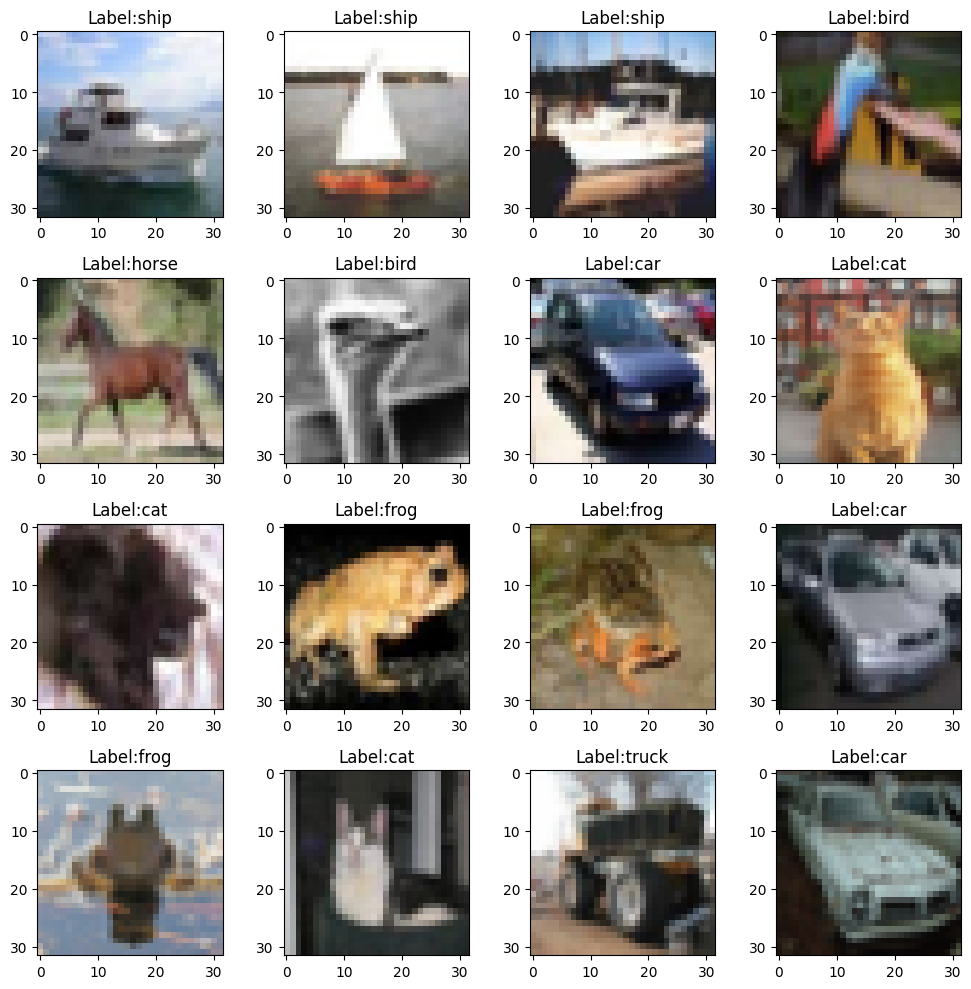

In [8]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
fig,axes=plt.subplots(4,4,figsize=(10,10))

for i in range(16):
    chosen=np.random.randint(0,50000)
    image=train.data[chosen]
    # image=image/2+.5
    ax=axes[i//4,i%4]
    ax.imshow(image)
    ax.set_title('Label:{}'.format(classes[train.targets[chosen]]))
plt.tight_layout()
plt.show


## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


# describing the model-
I used 2 conv layes with of sizes 5*5 and padding of 2 to preserver size. I used relu activation and MaxPooling between the conv layers. I also used 3 Linear layes and used Batch Normalization between them.
Finally I used the softmax classifier.

In [9]:
# define a child class of nn.Module for your model
# specify the architecture here itself
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5,padding=2)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5,padding=2)
        self.fc1=nn.Linear(16*8*8,120)
        self.bn1=nn.BatchNorm1d(120)
        self.fc2=nn.Linear(120,84)
        self.bn2=nn.BatchNorm1d(84)
        self.fc3=nn.Linear(84,10)
        self.relu=nn.ReLU()
        self.softmx=nn.Softmax(dim=-1)
    def forward(self,x):
        x=self.pool(self.relu(self.conv1(x)))
        x=self.pool(self.relu(self.conv2(x)))
        x=torch.flatten(x,1)
        x=self.relu(self.bn1(self.fc1(x)))
        x=self.relu(self.bn2(self.fc2(x)))
        x=self.softmx(self.fc3(x))
        return x
        
        

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

These are the hyperparameters to play with

In [131]:
n_epochs = 20
batch_size_train = 100
learning_rate = 0.001
momentum = 0.9
log_interval = 100

The training function

In [132]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    running_loss=0
    model.train()
    for batch_idx,(data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        output=model(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        if batch_idx%log_interval==(log_interval-1):
            print(f'[{batch_idx + 1:5d}] loss: {running_loss :.3f}')
            running_loss=0
    print("finished")

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [14]:
def predict(model, X_test):
    _,predicted=torch.max(model(X_test),1)
    return predicted

In [15]:
def accuracy(pred, labels):
    total=labels.size(0)
    correct=(pred==labels).sum().item()
    return 100*correct/total

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [135]:
import torch.optim as optim

model=Net()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
for i in range(n_epochs):
    train(model,optimizer=optimizer,criterion=F.nll_loss,train_loader=train_loader)
    

[  100] loss: -25.119
[  200] loss: -39.879
[  300] loss: -44.909
[  400] loss: -47.730
[  500] loss: -50.615
[  600] loss: -50.890
[  700] loss: -52.121
finished
[  100] loss: -55.552
[  200] loss: -55.121
[  300] loss: -54.871
[  400] loss: -57.669
[  500] loss: -56.552
[  600] loss: -57.917
[  700] loss: -56.934
finished
[  100] loss: -59.365
[  200] loss: -59.750
[  300] loss: -59.206
[  400] loss: -59.196
[  500] loss: -60.681
[  600] loss: -60.742
[  700] loss: -61.190
finished
[  100] loss: -62.382
[  200] loss: -62.206
[  300] loss: -62.632
[  400] loss: -63.400
[  500] loss: -63.631
[  600] loss: -63.214
[  700] loss: -62.806
finished
[  100] loss: -65.507
[  200] loss: -65.818
[  300] loss: -64.482
[  400] loss: -65.575
[  500] loss: -65.106
[  600] loss: -65.170
[  700] loss: -64.910
finished
[  100] loss: -67.264
[  200] loss: -66.267
[  300] loss: -67.775
[  400] loss: -67.011
[  500] loss: -66.821
[  600] loss: -65.857
[  700] loss: -66.153
finished
[  100] loss: -68.747


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [136]:
acc=0
i=0
for batch_idx,(data,target) in enumerate(val_loader):
    answer=predict(model,data)
    acc+=accuracy(answer,target)
    i+=1
print("accuracy{}".format({acc/i}))

accuracy{65.36787974683544}


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_3.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_3.pt``` model-weights file to the repository.

In [11]:
# from google.colab import files
torch.save(model, 'ass_3.pt')
saved_model=torch.load('ass_3.pt') # download the file from the Colab session for submission
saved_model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (softmx): Softmax(dim=-1)
)

Check if it got saved right!

In [16]:
# load the model, use predict function
with torch.no_grad():
    acc=0
    i=0
    for b,(d,t) in enumerate(test_loader):
        pred=predict(saved_model,d)
        acc+=accuracy(pred,t)
        i+=1
acc/i

65.57523885350318